# 0.0. IMPORTS

In [1]:
import math
import inflection

import pandas  as pd
import numpy   as np
import seaborn as sns

from IPython.core.display import HTML
from matplotlib           import pyplot as plt

ModuleNotFoundError: No module named 'inflection'

## 0.1. Functions

In [60]:
# jupyter design
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12,6]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Reading data

In [2]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. DATA DESCRIPTION

In [3]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [4]:
cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
        'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

# camelcase cols to snakecase
snakecase = lambda x: inflection.underscore( x )
new_cols = list( map( snakecase , cols ) )
new_cols

# renaming cols
df1.columns = new_cols

## 1.2. Data dimensions

In [5]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1]) )

Number of rows: 1017209
Number of columns: 18


## 1.3. Data types

In [6]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. NA check

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. NA fulfill

### competition_distance  

Premissa: se a coluna 'competion_distance' for NA, significa que a loja não tem nenhum competidor próximo. Dito isso, vou calcular o valor máximo dessa coluna e atribuir um valor maior que o máximo pra todas as colunas NA. Significa que todas as colunas que tiverem o valor maior, não apresentam competidores próximos.

In [8]:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 100000 if math.isnan( x ) else x )

### competition_open_since_ [month/year]

Premissa: se a coluna 'competition_open_since_ [month/year]' for NA, preencher com o mês e ano da coluna 'date'. 

**Não acho que isso faça sentido, já que pra uma mesma loja, um mesmo competidor abriria em várias datas diferentes.**

In [9]:
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

### promo2_since_ [week/year]

Premissa: se a coluna 'promo2_since [week/year]' for NA, preencher com a semana e ano da coluna 'date'. 

**Também não acho que isso faça sentido, já que se essa coluna for NA, significa que a loja não adota a promo2**

In [10]:
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

### promo_interval

In [11]:
month_map = { 1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12:'Dez' }

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else
                                                                       1 if x['month_map'] in x['promo_interval'] else 0, axis=1 )

## 1.6. Rechecking dtypes

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )
df1['is_promo'] = df1['is_promo'].astype( np.int64 )

## 1.7. Descriptive statistics

In [21]:
num_attributes = df1.select_dtypes( include=['int64','float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64','float64','datetime64[ns]'] )

### Numerical attributes

In [22]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion metrics - std, max, min, range, skewness, kurtosis
dm1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
dm2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
dm3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
dm4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T                    
dm5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
dm6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat
metrics = pd.concat( [dm2, dm3, dm4, ct1, ct2, dm1, dm5, dm6] ).T
metrics.columns = [ 'min','max','range','mean','median','std','skewness','kurtosis' ]
metrics

,min,max,range,mean,median,std,skewness,kurtosis
store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20.0,100000.0,99980.0,5675.712376,2330.0,9085.159292,4.637208,35.287543
competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### Categorical attributes

In [30]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

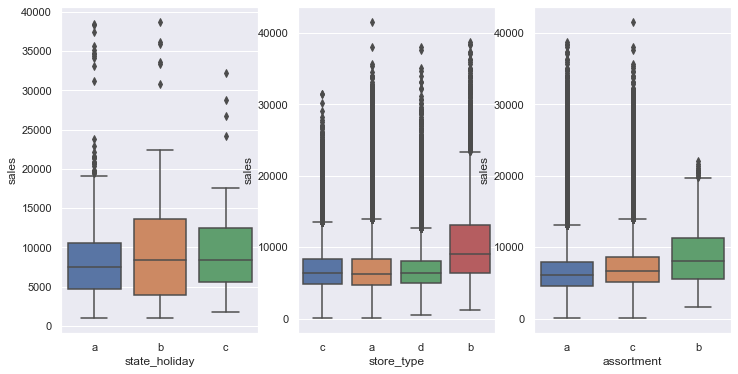

In [62]:
aux2 = df1[df1['sales'] > 0]

plt.subplot(1, 3, 1)
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
sns.boxplot( x='state_holiday', y='sales', data=aux );

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux2 );

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux2 );